In [ ]:
#@title 0) Install Dependencies
!pip -q install torch torchvision torchaudio
!pip -q install sentencepiece tqdm pandas nltk matplotlib scikit-learn

import os, re, glob, random, math
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

from PIL import Image
import matplotlib.pyplot as plt

import nltk
nltk.download("punkt")
nltk.download("wordnet")

print("✅ Installed & imported.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Installed & imported.


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# ============================================================
#@title 1) Mount Drive & Set Paths (EDIT DATA_ROOT ONLY)
# ============================================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_ROOT = "/content/drive/My Drive/CVPR"  # <-- edit if needed
IMG_DIR   = os.path.join(DATA_ROOT, "BNLIT")
TRAIN_ANN = os.path.join(DATA_ROOT, "Train-Annotation.txt")
TEST_ANN  = os.path.join(DATA_ROOT, "Test-Annotation.txt")

for p in [IMG_DIR, TRAIN_ANN, TEST_ANN]:
    assert os.path.exists(p), f"Missing path: {p}"

print("✅ Paths OK")
print("IMG_DIR  :", IMG_DIR)
print("TRAIN_ANN:", TRAIN_ANN)
print("TEST_ANN :", TEST_ANN)


Mounted at /content/drive
✅ Paths OK
IMG_DIR  : /content/drive/My Drive/CVPR/BNLIT
TRAIN_ANN: /content/drive/My Drive/CVPR/Train-Annotation.txt
TEST_ANN : /content/drive/My Drive/CVPR/Test-Annotation.txt


In [ ]:
#@title 2) Parse Annotations (NO MERGING) + Split Train→Train/Val

def parse_annotations(file_path, img_dir, verbose=False, limit=None):
    rows, missing = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for ln, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            parts = s.split('\t', 1) if '\t' in s else s.split(maxsplit=1)
            if len(parts) < 2:
                if verbose:
                    print(f"⚠️ Bad line {ln}: {s[:100]}")
                continue

            fname_raw, caption = parts[0].strip(), parts[1].strip()
            fname = os.path.basename(fname_raw)
            cand = os.path.join(img_dir, fname)

            if os.path.exists(cand):
                rows.append((cand, caption))
            else:
                stem = os.path.splitext(fname)[0]
                ms = glob.glob(os.path.join(img_dir, stem + '.*'))
                ms = [m for m in ms if m.lower().endswith(('.jpg','.jpeg','.png'))]
                if ms:
                    rows.append((ms[0], caption))
                else:
                    missing.append(fname)

            if limit and len(rows) >= limit:
                break

    if verbose and missing:
        print(f"⚠️ Missing {len(missing)} images (first 10): {missing[:10]}")
    return pd.DataFrame(rows, columns=["image_path", "caption_bn"])

train_df_full = parse_annotations(TRAIN_ANN, IMG_DIR, verbose=True)
test_df       = parse_annotations(TEST_ANN,  IMG_DIR, verbose=True)

print("Train-Annotation size:", len(train_df_full))
print("Test-Annotation  size:", len(test_df))

# --- Split TRAIN_ANN into train/val (80/20) ---
from sklearn.model_selection import train_test_split
SEED = 42

train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.20,
    random_state=SEED,
    shuffle=True
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(f"✅ Split: train={len(train_df)}, val={len(val_df)}, test={len(test_df)} (test untouched)")
display(train_df.head())
display(val_df.head())
display(test_df.head())


⚠️ Bad line 5838: ji_ts_tf_945.jpg#পানি
⚠️ Bad line 6892: ji_ts_tf_1999.jpg#মহাখালি
⚠️ Bad line 6893: ji_ts_tf_2000.jpg#মহাখালি
⚠️ Bad line 6895: ji_ts_tf_2002.jpg#মহাখালি
⚠️ Missing 3261 images (first 10): ['img_0000037.jpeg', 'img_0000149.jpeg', 'img_0000152.jpeg', 'img_0000175.jpeg', 'img_0000180.jpeg', 'img_0000187.jpeg', 'img_0000213.jpeg', 'img_0000280.jpeg', 'img_0000290.jpeg', 'img_0000343.jpeg']
Train-Annotation size: 4978
Test-Annotation  size: 500
✅ Split: train=3982, val=996, test=500 (test untouched)


,image_path,caption_bn
0,/content/drive/My Drive/CVPR/BNLIT/Ji_1886.jpg,#একটি মেয়ে শাড়ি পরে বসে আছে।
1,/content/drive/My Drive/CVPR/BNLIT/img_0000772...,#বেশকিছু ভবন দেখা যায়।
2,/content/drive/My Drive/CVPR/BNLIT/Ji_2475.JPG,#একটি বাচ্চা খাবার খাইয়ে দিচ্ছে।
3,/content/drive/My Drive/CVPR/BNLIT/Ji_2338.JPG,#মেয়েটি দেয়ালে হেলান দিয়ে দাড়িয়ে।
4,/content/drive/My Drive/CVPR/BNLIT/0273.png,মাঝে রাস্তার মোর দিয়ে একজন রিক্সা চালিয়ে যাচ্ছ...


,image_path,caption_bn
0,/content/drive/My Drive/CVPR/BNLIT/Ji_2464.JPG,#বাচ্চারা বেলুন নিয়ে খেলছে।
1,/content/drive/My Drive/CVPR/BNLIT/img_0000146...,# চারটি হরিন বনের মাঝে দৌড়ায়।
2,/content/drive/My Drive/CVPR/BNLIT/Ji_1534.jpg,#মেয়ে দুটি পুকুর পাড়ে বসে আছে।
3,/content/drive/My Drive/CVPR/BNLIT/Ji_3296.JPG,#দুটি মেয়ে ফুলে হাত দিয়ে দাড়িয়ে আছে।
4,/content/drive/My Drive/CVPR/BNLIT/Ji_1046.JPG,#বন্দধুরা মজা করে ছবি তুলছে।


,image_path,caption_bn
0,/content/drive/My Drive/CVPR/BNLIT/1.png,#একটি ছেলে ব্রিজের রেলিংয়ে দাড়িয়ে আছে।
1,/content/drive/My Drive/CVPR/BNLIT/2.png,#একটি ছেলে দেয়ালে হেলান দিয়ে দাড়িয়ে আছে।
2,/content/drive/My Drive/CVPR/BNLIT/3.png,#দুইটি ছেলে একটি গরু নিয়ে ব্রিজের উপর দাড়িয়ে আছে।
3,/content/drive/My Drive/CVPR/BNLIT/4.png,#চারজন ছেলে আড্ডায় কথোপকথন করে হাসছে।
4,/content/drive/My Drive/CVPR/BNLIT/5.png,#তিনজন ছেলে সার্ট এর দোকানে দাড়িয়ে আছে।


In [ ]:
#@title 3) SentencePiece Tokenizer (TRAIN ONLY) + Safe Special Tokens

import sentencepiece as spm

SPM_PREFIX = "/content/spm_bnlit_trainonly"
SPM_MODEL  = SPM_PREFIX + ".model"

PAD, BOS, EOS = 0, 1, 2
SP_OFFSET = 3  # shift sentencepiece ids by +3 to avoid collisions

if not os.path.exists(SPM_MODEL):
    corpus_path = "/content/corpus_train_only.txt"
    with open(corpus_path, "w", encoding="utf-8") as f:
        for c in train_df["caption_bn"].astype(str).tolist():
            f.write(c.strip() + "\n")

    vocab_size = 6000
    spm.SentencePieceTrainer.Train(
        f"--input={corpus_path} --model_prefix={SPM_PREFIX} "
        f"--vocab_size={vocab_size} --character_coverage=0.9995 --model_type=bpe "
        f"--unk_id=0"
    )

tok = spm.SentencePieceProcessor(model_file=SPM_MODEL)
VOCAB_SIZE = tok.get_piece_size() + SP_OFFSET

MAX_LEN = 40

def encode_caption(text, max_len=MAX_LEN):
    sp_ids = tok.encode(text or "", out_type=int)
    sp_ids = [i + SP_OFFSET for i in sp_ids]
    ids = [BOS] + sp_ids[:max_len-2] + [EOS]
    ids += [PAD] * (max_len - len(ids))
    return ids

def decode_ids(ids):
    ids = [i for i in ids if i not in (PAD, BOS, EOS)]
    ids = [i - SP_OFFSET for i in ids if i >= SP_OFFSET]
    return tok.decode(ids)

print("✅ Tokenizer ready")
print("VOCAB_SIZE:", VOCAB_SIZE)
example = encode_caption(train_df.iloc[0]["caption_bn"])
print("Example encoded (first 12):", example[:12])
print("Decoded:", decode_ids(example))


✅ Tokenizer ready
VOCAB_SIZE: 6003
Example encoded (first 12): [1, 8, 23, 24, 197, 169, 36, 18, 5955, 2, 0, 0]
Decoded: #একটি মেয়ে শাড়ি পরে বসে আছে।


In [ ]:
#@title 4) Dataset + DataLoaders
from torchvision import transforms

IMG_SIZE = 224

img_tf_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

img_tf_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

class CapDS(Dataset):
    def __init__(self, df, tf, max_len=MAX_LEN):
        self.df = df.reset_index(drop=True)
        self.tf = tf
        self.max_len = max_len
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.image_path).convert("RGB")
        img = self.tf(img)
        ids = torch.tensor(encode_caption(row.caption_bn, self.max_len), dtype=torch.long)
        return img, ids, row.image_path

def collate(batch):
    imgs, ids, paths = zip(*batch)
    return torch.stack(imgs,0), torch.stack(ids,0), list(paths)

BATCH = 32
train_loader = DataLoader(CapDS(train_df, img_tf_train), batch_size=BATCH, shuffle=True,  num_workers=2, collate_fn=collate)
val_loader   = DataLoader(CapDS(val_df,   img_tf_eval),  batch_size=BATCH, shuffle=False, num_workers=2, collate_fn=collate)
test_loader  = DataLoader(CapDS(test_df,  img_tf_eval),  batch_size=BATCH, shuffle=False, num_workers=2, collate_fn=collate)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ device:", device)


✅ device: cuda


In [ ]:
#@title 5) Model: ViT Encoder + CAF + Transformer Decoder

from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

class ViTEncoder(nn.Module):
    def __init__(self, d_model=384, freeze_layers=0):
        super().__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.proj = nn.Linear(self.vit.hidden_dim, d_model) if self.vit.hidden_dim != d_model else nn.Identity()
        for i, blk in enumerate(self.vit.encoder.layers):
            if i < freeze_layers:
                for p in blk.parameters():

                    p.requires_grad = False

    def forward(self, x):
        x = self.vit._process_input(x)
        n = x.size(0)
        cls = self.vit.class_token.expand(n, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = x + self.vit.encoder.pos_embedding
        x = self.vit.encoder.dropout(x)
        x = self.vit.encoder.layers(x)
        x = self.vit.encoder.ln(x)
        V = x[:, 1:, :]
        return self.proj(V)

class CAF(nn.Module):
    def __init__(self, d_model=384, n_heads=6, dropout=0.1, tokenwise=False, residual_drop=0.1):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.tokenwise = tokenwise
        if tokenwise:
            self.gate = nn.Sequential(nn.Linear(2*d_model, d_model), nn.Sigmoid())
        else:
            self.gate = nn.Sequential(nn.Linear(2*d_model, d_model), nn.ReLU(),
                                      nn.Linear(d_model, 1), nn.Sigmoid())
        self.resdrop = nn.Dropout(residual_drop) if residual_drop else nn.Identity()

    def forward(self, V):
        X = self.ln(V)
        C, _ = self.mha(X, X, X, need_weights=False)
        meanC, meanV = C.mean(1), V.mean(1)
        u = torch.cat([meanC, meanV], dim=-1)
        if self.tokenwise:
            u = u.unsqueeze(1).expand(-1, V.size(1), -1)
            g = self.gate(u)
        else:
            g = self.gate(u).unsqueeze(1)
        return V + self.resdrop(g * C)

class CAFStack(nn.Module):
    def __init__(self, layers=2, d_model=384, n_heads=6, tokenwise=False):
        super().__init__()
        self.layers = nn.ModuleList([CAF(d_model, n_heads, tokenwise=tokenwise) for _ in range(layers)])
    def forward(self, V):
        for blk in self.layers:
            V = blk(V)
        return V

class DecoderLayer(nn.Module):
    def __init__(self, d_model=384, heads=6, ff=4.0, drop=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.sa  = nn.MultiheadAttention(d_model, heads, dropout=drop, batch_first=True)
        self.ln2 = nn.LayerNorm(d_model)
        self.ca  = nn.MultiheadAttention(d_model, heads, dropout=drop, batch_first=True)
        self.ln3 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, int(ff*d_model)), nn.GELU(), nn.Dropout(drop),
            nn.Linear(int(ff*d_model), d_model)
        )
        self.drop = nn.Dropout(drop)

    def forward(self, x, mem, tgt_mask=None, pad_mask=None):
        y, _ = self.sa(self.ln1(x), self.ln1(x), self.ln1(x),
                       attn_mask=tgt_mask, key_padding_mask=pad_mask, need_weights=False)
        x = x + self.drop(y)
        y, _ = self.ca(self.ln2(x), mem, mem, need_weights=False)
        x = x + self.drop(y)
        y = self.ffn(self.ln3(x))
        x = x + self.drop(y)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab, d_model=384, heads=6, layers=4, pad_id=PAD, drop=0.1, max_len=512):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=pad_id)
        self.pos = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, 4.0, drop) for _ in range(layers)])
        self.ln = nn.LayerNorm(d_model)
        self.lm = nn.Linear(d_model, vocab)
        self.pad_id = pad_id
        self.d_model = d_model

    def forward(self, ids, mem):
        B, T = ids.shape
        pos_ids = torch.arange(T, device=ids.device).unsqueeze(0).expand(B, T)
        x = self.emb(ids) * (self.d_model ** 0.5) + self.pos(pos_ids)
        causal = torch.triu(torch.ones(T, T, device=ids.device, dtype=torch.bool), 1)
        pad_mask = (ids == self.pad_id)
        for lyr in self.layers:
            x = lyr(x, mem, tgt_mask=causal, pad_mask=pad_mask)
        x = self.ln(x)
        return self.lm(x)

class CaptionModel(nn.Module):
    def __init__(self, vocab_size, d_model=384, heads=6, dec_layers=4,
                 caf_layers=2, caf_tokenwise=False, vit_freeze=0, pad_id=PAD):
        super().__init__()
        self.enc = ViTEncoder(d_model=d_model, freeze_layers=vit_freeze)
        self.caf = CAFStack(layers=caf_layers, d_model=d_model, n_heads=heads, tokenwise=caf_tokenwise)
        self.dec = TransformerDecoder(vocab=vocab_size, d_model=d_model, heads=heads, layers=dec_layers, pad_id=pad_id)

    def encode_imgs(self, images):
        V = self.enc(images)
        return self.caf(V)

    def forward(self, images, tgt_in):
        mem = self.encode_imgs(images)
        return self.dec(tgt_in, mem)

model = CaptionModel(
    vocab_size=VOCAB_SIZE,
    d_model=384,
    heads=6,
    dec_layers=4,
    caf_layers=2,
    caf_tokenwise=False,
    vit_freeze=0,
    pad_id=PAD
).to(device)

print("✅ Model params (M):", round(sum(p.numel() for p in model.parameters())/1e6, 2))


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:04<00:00, 84.5MB/s]


✅ Model params (M): 102.92


In [ ]:
#@title 6) Training Utilities (Loss, Token Accuracy, BLEU-1..4 + METEOR)

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

_punct = r'([।!?,;:()"“”\'\-–—])'
def bn_tokenize(s: str):
    s = re.sub(_punct, r' \1 ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s.split()

def token_accuracy(logits, tgt_out, pad_id=PAD):
    pred = logits.argmax(-1)
    mask = (tgt_out != pad_id)
    correct = (pred == tgt_out) & mask
    denom = mask.sum().clamp(min=1).item()
    return correct.sum().item() / denom

def corpus_bleu_1to4_meteor(refs, hyps):
    """
    refs, hyps: list[str] of equal length.
    Returns dict: BLEU-1..4 + METEOR
    """
    refs_tok = [[bn_tokenize(r)] for r in refs]
    hyps_tok = [bn_tokenize(h) for h in hyps]
    smoothie = SmoothingFunction().method4

    bleu1 = corpus_bleu(refs_tok, hyps_tok, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = corpus_bleu(refs_tok, hyps_tok, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = corpus_bleu(refs_tok, hyps_tok, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smoothie)
    bleu4 = corpus_bleu(refs_tok, hyps_tok, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    meteor = float(np.mean([
        meteor_score([bn_tokenize(r)], bn_tokenize(h))
        for r, h in zip(refs, hyps)
    ]))

    return {
        "BLEU-1": float(bleu1),
        "BLEU-2": float(bleu2),
        "BLEU-3": float(bleu3),
        "BLEU-4": float(bleu4),
        "METEOR": meteor
    }


In [ ]:
#@title 7) Beam Search (Correct Length Penalty + Correct SentencePiece Shift)

def generate_beam(model, img_tensor, max_len=MAX_LEN, beam=5, lp=0.8):
    model.eval()
    with torch.no_grad():
        mem = model.encode_imgs(img_tensor.unsqueeze(0).to(device))
        beams = [(torch.tensor([BOS], device=device), 0.0)]  # (seq, sum_logp)

        for _ in range(max_len-1):
            cand = []
            for seq, sum_logp in beams:
                if seq[-1].item() == EOS:
                    cand.append((seq, sum_logp))
                    continue

                logits = model.dec(seq.unsqueeze(0), mem)[0, -1]
                logp = F.log_softmax(logits, dim=-1)
                topk = torch.topk(logp, beam)

                for idx, val in zip(topk.indices, topk.values):
                    new_seq = torch.cat([seq, idx.view(1)])
                    cand.append((new_seq, sum_logp + float(val)))

            def rank(item):
                seq, s = item
                return s / (len(seq) ** lp)

            cand.sort(key=rank, reverse=True)
            beams = cand[:beam]

        best_seq = max(beams, key=lambda x: x[1] / (len(x[0]) ** lp))[0].tolist()

    ids = [i for i in best_seq if i not in (PAD, BOS, EOS)]
    ids = [i - SP_OFFSET for i in ids if i >= SP_OFFSET]
    return tok.decode(ids)

print("✅ Beam search ready.")


✅ Beam search ready.


In [ ]:
# ============================================================
#@title 8) Train with Early Stopping + Scheduler + Track Train/Val/Test Sets
# ============================================================
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-4, mode="max", ckpt_path="/content/best_caption_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.ckpt_path = ckpt_path
        self.best = -1e18 if mode == "max" else 1e18
        self.bad = 0

    def improved(self, val):
        if self.mode == "max":
            return val > (self.best + self.min_delta)
        return val < (self.best - self.min_delta)

    def step(self, metric_value, model, extra=None):
        if self.improved(metric_value):
            self.best = metric_value
            self.bad = 0
            torch.save({"model": model.state_dict(), "best_metric": metric_value, "extra": extra}, self.ckpt_path)
            return False
        self.bad += 1
        return self.bad >= self.patience

def run_epoch(model, loader, optimizer=None, scaler=None, train=True):
    crit = nn.CrossEntropyLoss(ignore_index=PAD, label_smoothing=0.1)
    model.train() if train else model.eval()

    total_loss, total_acc, steps = 0.0, 0.0, 0

    for imgs, ids, _ in tqdm(loader, desc=("Train" if train else "Val"), leave=False):
        imgs, ids = imgs.to(device), ids.to(device)
        tgt_in, tgt_out = ids[:, :-1], ids[:, 1:]

        if train:
            optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
            logits = model(imgs, tgt_in)
            loss = crit(logits.reshape(-1, VOCAB_SIZE), tgt_out.reshape(-1))

        acc = token_accuracy(logits, tgt_out, PAD)

        if train:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

        total_loss += float(loss)
        total_acc  += float(acc)
        steps += 1

    return total_loss/steps, total_acc/steps

def eval_bleu_meteor(model, loader, beam=3, limit=None):
    """
    Generates captions for the loader and returns dict:
    BLEU-1..4 + METEOR
    """
    refs, hyps = [], []
    model.eval()
    with torch.no_grad():
        seen = 0
        for imgs, ids, _ in tqdm(loader, desc="Gen(Eval)", leave=False):
            imgs = imgs.to(device)
            B = imgs.size(0)
            for i in range(B):
                hyp = generate_beam(model, imgs[i].detach().cpu(), max_len=MAX_LEN, beam=beam)
                ref = decode_ids(ids[i].tolist())
                hyps.append(hyp)
                refs.append(ref)
                seen += 1
                if limit and seen >= limit:
                    break
            if limit and seen >= limit:
                break
    return corpus_bleu_1to4_meteor(refs, hyps)

# --- Training config ---
EPOCHS = 30
LR = 3e-4

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.05)
scaler = GradScaler("cuda" if device=="cuda" else "cpu")
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

early = EarlyStopping(patience=6, min_delta=1e-4, mode="max", ckpt_path="/content/best_caption_model.pt")

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [],  "val_acc": [],
    "val_BLEU-1": [], "val_BLEU-2": [], "val_BLEU-3": [], "val_BLEU-4": [],
    "val_METEOR": []
}

print("📌 Tracking datasets:")
print("  train:", len(train_df))
print("  val  :", len(val_df))
print("  test :", len(test_df), "(never used for early stopping)")

for ep in range(EPOCHS):
    tr_loss, tr_acc = run_epoch(model, train_loader, optimizer, scaler, train=True)
    va_loss, va_acc = run_epoch(model, val_loader, train=False)

    # BLEU/METEOR on validation (beam=3 faster). You can add limit=500 to speed up.
    val_metrics = eval_bleu_meteor(model, val_loader, beam=3, limit=None)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    history["val_BLEU-1"].append(val_metrics["BLEU-1"])
    history["val_BLEU-2"].append(val_metrics["BLEU-2"])
    history["val_BLEU-3"].append(val_metrics["BLEU-3"])
    history["val_BLEU-4"].append(val_metrics["BLEU-4"])
    history["val_METEOR"].append(val_metrics["METEOR"])

    scheduler.step(val_metrics["METEOR"])

    print(
        f"Epoch {ep:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"val loss {va_loss:.4f} acc {va_acc:.4f} | "
        f"val BLEU1 {val_metrics['BLEU-1']:.4f} "
        f"BLEU2 {val_metrics['BLEU-2']:.4f} "
        f"BLEU3 {val_metrics['BLEU-3']:.4f} "
        f"BLEU4 {val_metrics['BLEU-4']:.4f} "
        f"METEOR {val_metrics['METEOR']:.4f}"
    )

    # early stopping uses METEOR
    if early.step(val_metrics["METEOR"], model, extra={"epoch": ep, "history": history}):
        print(f"🛑 Early stopping at epoch {ep}. Best val METEOR={early.best:.4f}")
        break

# Load best checkpoint
ck = torch.load("/content/best_caption_model.pt", map_location=device)
model.load_state_dict(ck["model"])
print("✅ Loaded best checkpoint. Best val METEOR:", ck["best_metric"])


📌 Tracking datasets:
  train: 3982
  val  : 996
  test : 500 (never used for early stopping)


Train:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-2048695431.py:56: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  total_loss += float(loss)


Epoch 00 | train loss 4.4835 acc 0.4544 | val loss 4.0351 acc 0.5027 | val BLEU1 0.3432 BLEU2 0.2382 BLEU3 0.1772 BLEU4 0.1147 METEOR 0.2967


Epoch 01 | train loss 3.5230 acc 0.5400 | val loss 3.8017 acc 0.5348 | val BLEU1 0.3432 BLEU2 0.2382 BLEU3 0.1772 BLEU4 0.1147 METEOR 0.2967


Epoch 02 | train loss 3.2685 acc 0.5675 | val loss 3.6919 acc 0.5446 | val BLEU1 0.3432 BLEU2 0.2382 BLEU3 0.1772 BLEU4 0.1147 METEOR 0.2967


Epoch 03 | train loss 3.0993 acc 0.5839 | val loss 3.6380 acc 0.5529 | val BLEU1 0.3432 BLEU2 0.2382 BLEU3 0.1772 BLEU4 0.1147 METEOR 0.2967


Epoch 04 | train loss 2.9529 acc 0.6006 | val loss 3.6025 acc 0.5627 | val BLEU1 0.3432 BLEU2 0.2382 BLEU3 0.1772 BLEU4 0.1147 METEOR 0.2967


Epoch 05 | train loss 2.8904 acc 0.6088 | val loss 3.5827 acc 0.5669 | val BLEU1 0.3432 BLEU2 0.2382 BLEU3 0.1772 BLEU4 0.1147 METEOR 0.2967


Epoch 06 | train loss 2.8320 acc 0.6188 | val loss 3.5775 acc 0.5681 | val BLEU1 0.3432 BLEU2 0.2382 BLEU3 0.1772 BLEU4 0.1147 METEOR 0.2967
🛑 Early stopping at epoch 6. Best val METEOR=0.2967
✅ Loaded best checkpoint. Best val METEOR: 0.29667285441461194


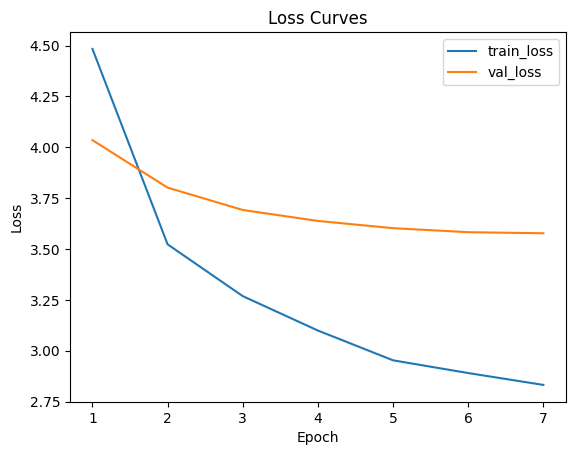

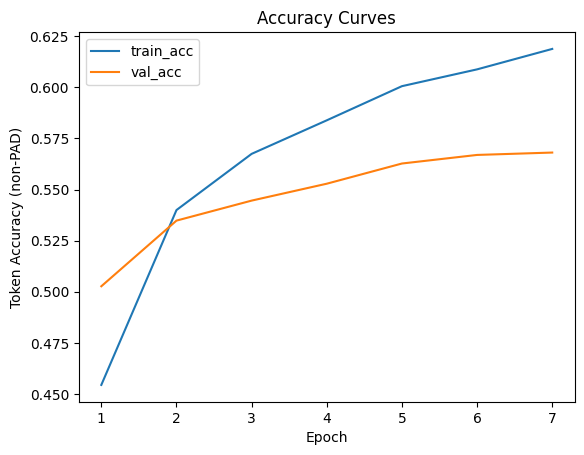

In [ ]:
#@title 9) Plot Curves (Train vs Val): Loss + Token Accuracy
epochs_r = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_r, history["train_loss"], label="train_loss")
plt.plot(epochs_r, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_r, history["train_acc"], label="train_acc")
plt.plot(epochs_r, history["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Token Accuracy (non-PAD)")
plt.title("Accuracy Curves")
plt.legend()
plt.show()


In [ ]:
# ============================================================
#@title 10) Final Evaluation on TEST (BLEU-1..4 + METEOR)
# ============================================================
test_metrics = eval_bleu_meteor(model, test_loader, beam=5, limit=None)

print("✅ TEST RESULTS")
for k in ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "METEOR"]:
    print(f"{k:7s}: {test_metrics[k]:.4f}")


✅ TEST RESULTS
BLEU-1 : 0.3900
BLEU-2 : 0.2820
BLEU-3 : 0.1995
BLEU-4 : 0.0859
METEOR : 0.3909


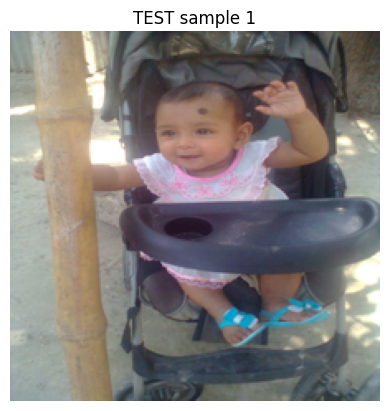

True Caption     : #একটি ছোট মেয়ে বাচ্চা।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
----------------------------------------------------------------------


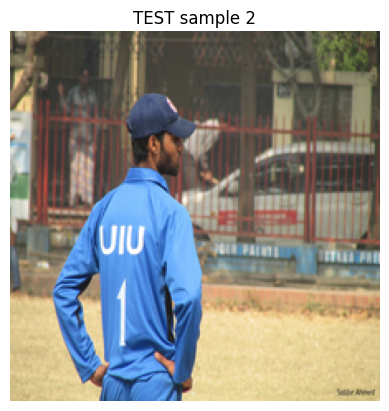

True Caption     : #ক্রিকেটার ক্রিকেট খেলছে।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
----------------------------------------------------------------------


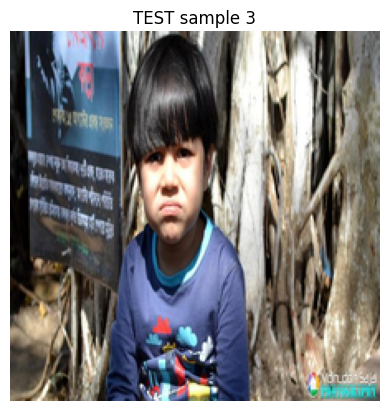

True Caption     : #একটি ছোট বাচ্চা মেয়ে।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
----------------------------------------------------------------------


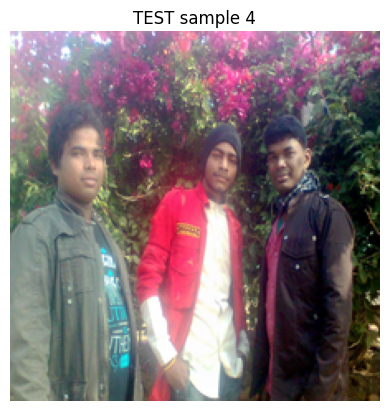

True Caption     : #তিনজন ছেরে দাড়িয়ে আছে।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
----------------------------------------------------------------------


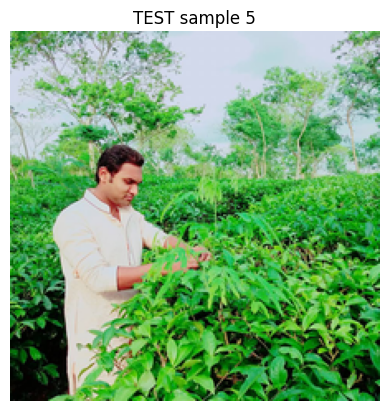

True Caption     : #একজন লোক দাড়িয়ে গাছের পাত ছিড়ছে।
Generated Caption: #একটি মেয়ে দাড়িয়ে আছে।
----------------------------------------------------------------------


In [ ]:
# ============================================================
#@title 11) Show 5 TEST Images + Generated Captions (Your Model)
# ============================================================
def show_test_samples(model, test_df, k=5, beam=5):
    idxs = random.sample(range(len(test_df)), k)
    model.eval()

    for j, i in enumerate(idxs, 1):
        img_path = test_df.iloc[i]["image_path"]
        ref = test_df.iloc[i]["caption_bn"]

        img = Image.open(img_path).convert("RGB")
        img_t = img_tf_eval(img).to(device)

        hyp = generate_beam(model, img_t.detach().cpu(), max_len=MAX_LEN, beam=beam)

        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"TEST sample {j}")
        plt.show()

        print("True Caption     :", ref)
        print("Generated Caption:", hyp)
        print("-"*70)

show_test_samples(model, test_df, k=5, beam=5)
